In [ ]:
import sys
sys.path.append('..')

from Controllers.FLController import *
from Controllers.LQGController import * 
from Controllers.ILQGController import *

from Controllers.NMPC import *

# First Movement

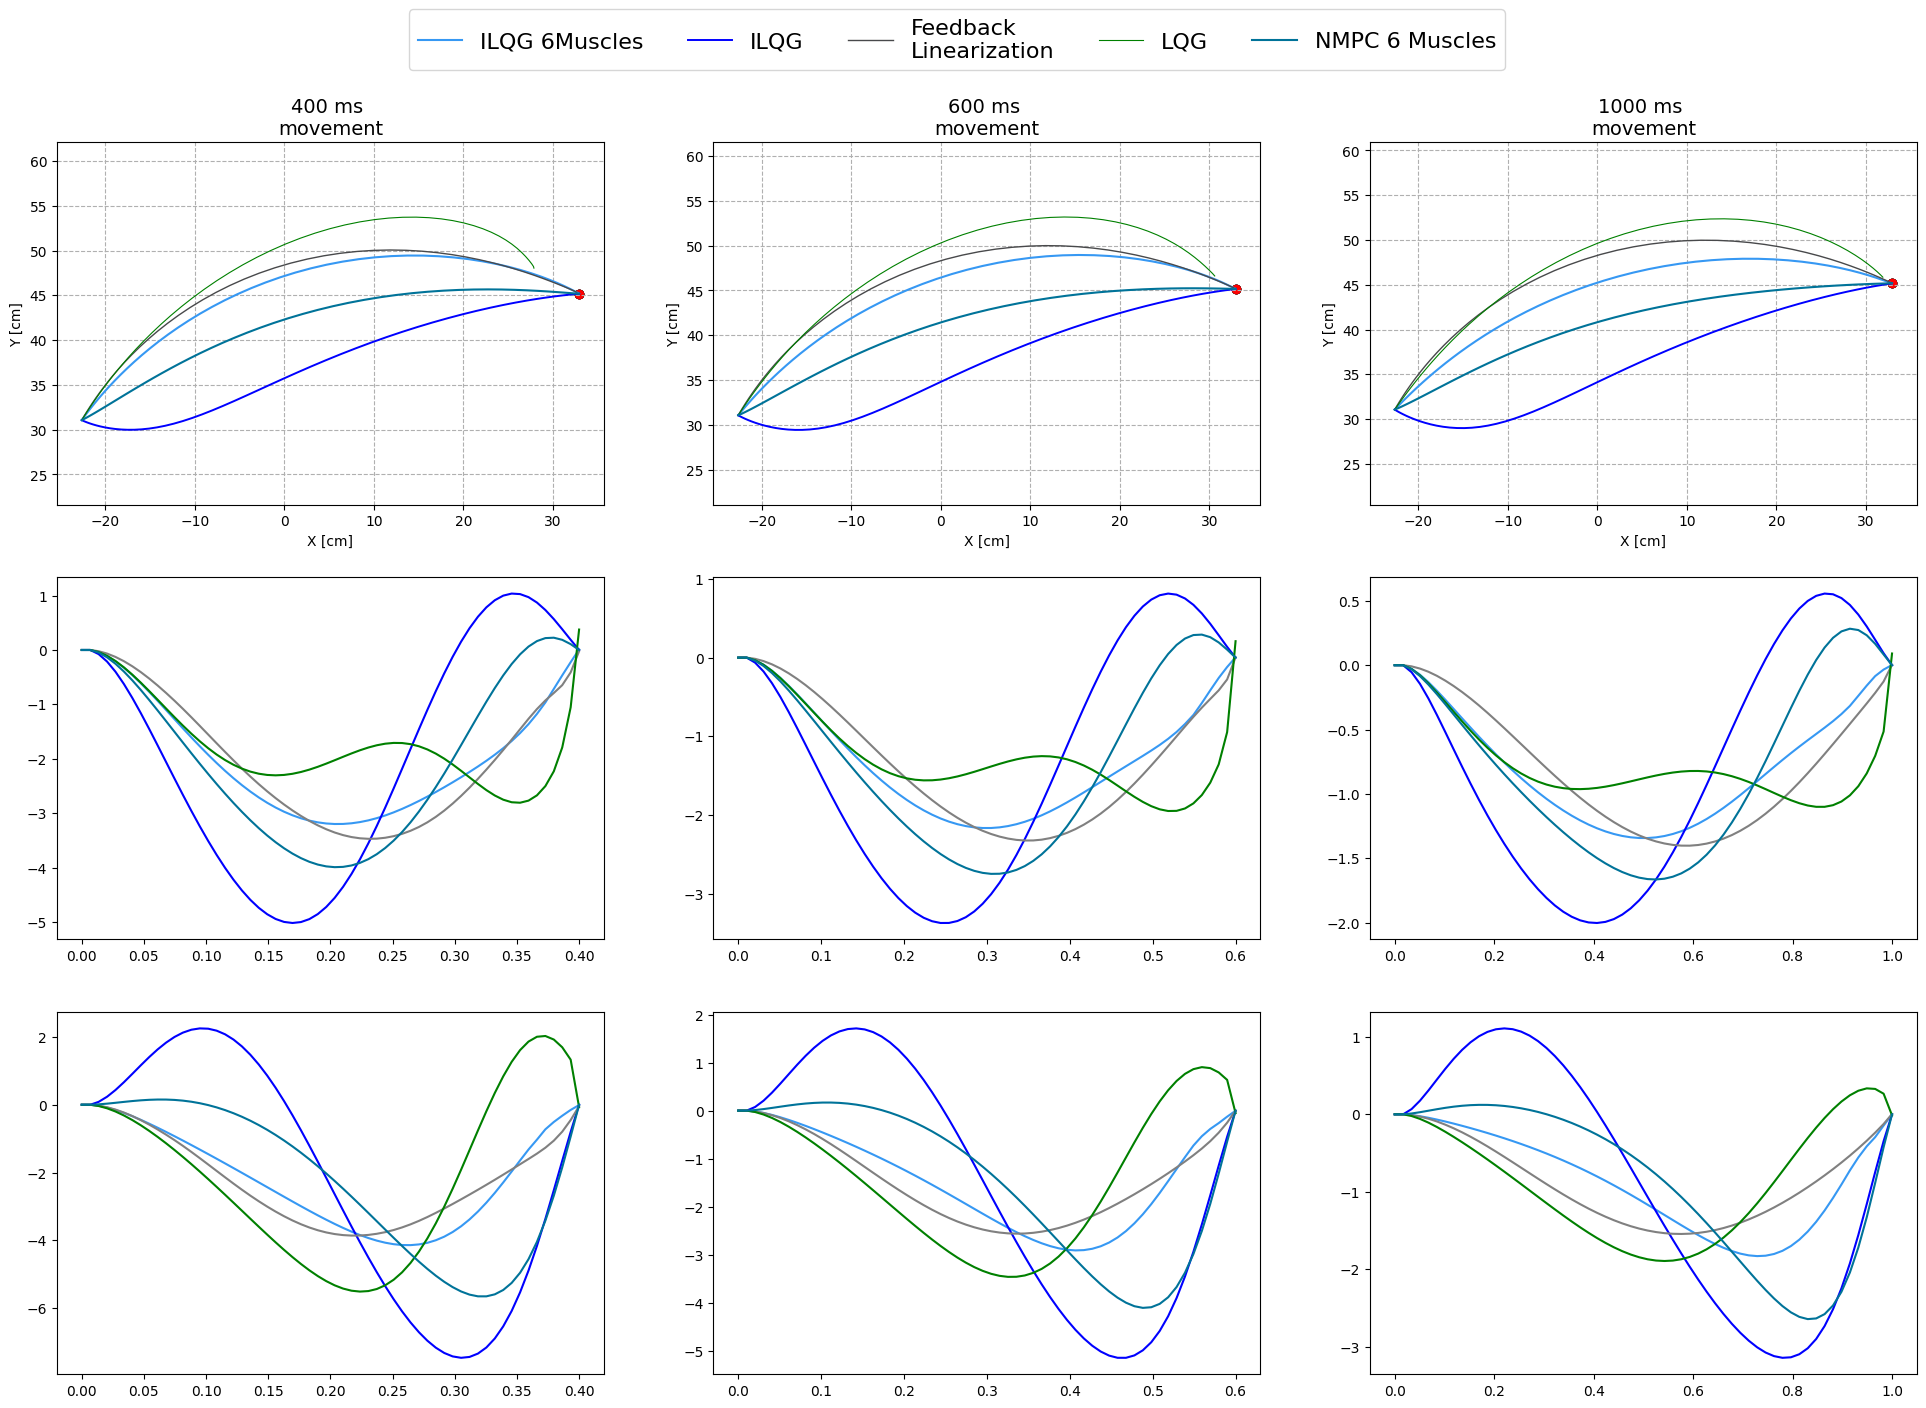

In [50]:

fig,ax = plt.subplots(3,3,figsize = (24,16))
T = [.4,.6,1]
tg = ToCartesian(np.array([25,55])/180*pi)
st = ToCartesian(np.array([70,105])/180*pi)

for i in range(3):
    plt.subplot(3,3,i+1)
    plt.axis("equal")
    D = T[i]
    K = 60
    xmuscle = ILQGMuscle(Duration = D,r1 = 1e-4,K=K,targets = tg,start = st ,eps= 1e-4*(i+1))[3]
    xilqg = ILQG(Duration = D,targets = tg,start = st)[3]
    xfl = Feedback_Linearization(Duration = D,targets = tg,starting_point = st,ShowJ=True,Num_iter = K)[3]
    xlqg = BestLQG(Duration = D,targets = tg, starting_point=st)[3]
    xmpc = MPC42(Duration = D,end = tg, start=st,n_steps = K)
    plt.legend().remove()
    plt.title(str(int(T[i]*1000))+" ms \nmovement",fontsize = 14)
    if i == 0 : fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
    plt.subplot(3,3,4+i)
    t = np.linspace(0,D,K)
    plt.plot(t,xmuscle[:,2],color = "#3698f3")
    plt.plot(t,xilqg[:,2],color = "blue")
    plt.plot(t,xfl[:,2],color = "grey")
    plt.plot(t,xlqg[1],color = "green")
    plt.plot(t,xmpc[2],color = "#007399")

    plt.subplot(3,3,7+i)
    t = np.linspace(0,D,K)
    plt.plot(t,xmuscle[:,3],color = "#3698f3")
    plt.plot(t,xilqg[:,3],color = "blue")
    plt.plot(t,xfl[:,3],color = "grey")
    plt.plot(t,xlqg[4],color = "green")
    plt.plot(t,xmpc[3],color = "#007399")

plt.savefig("img/AlwaysOvershoot.png",dpi = 200)

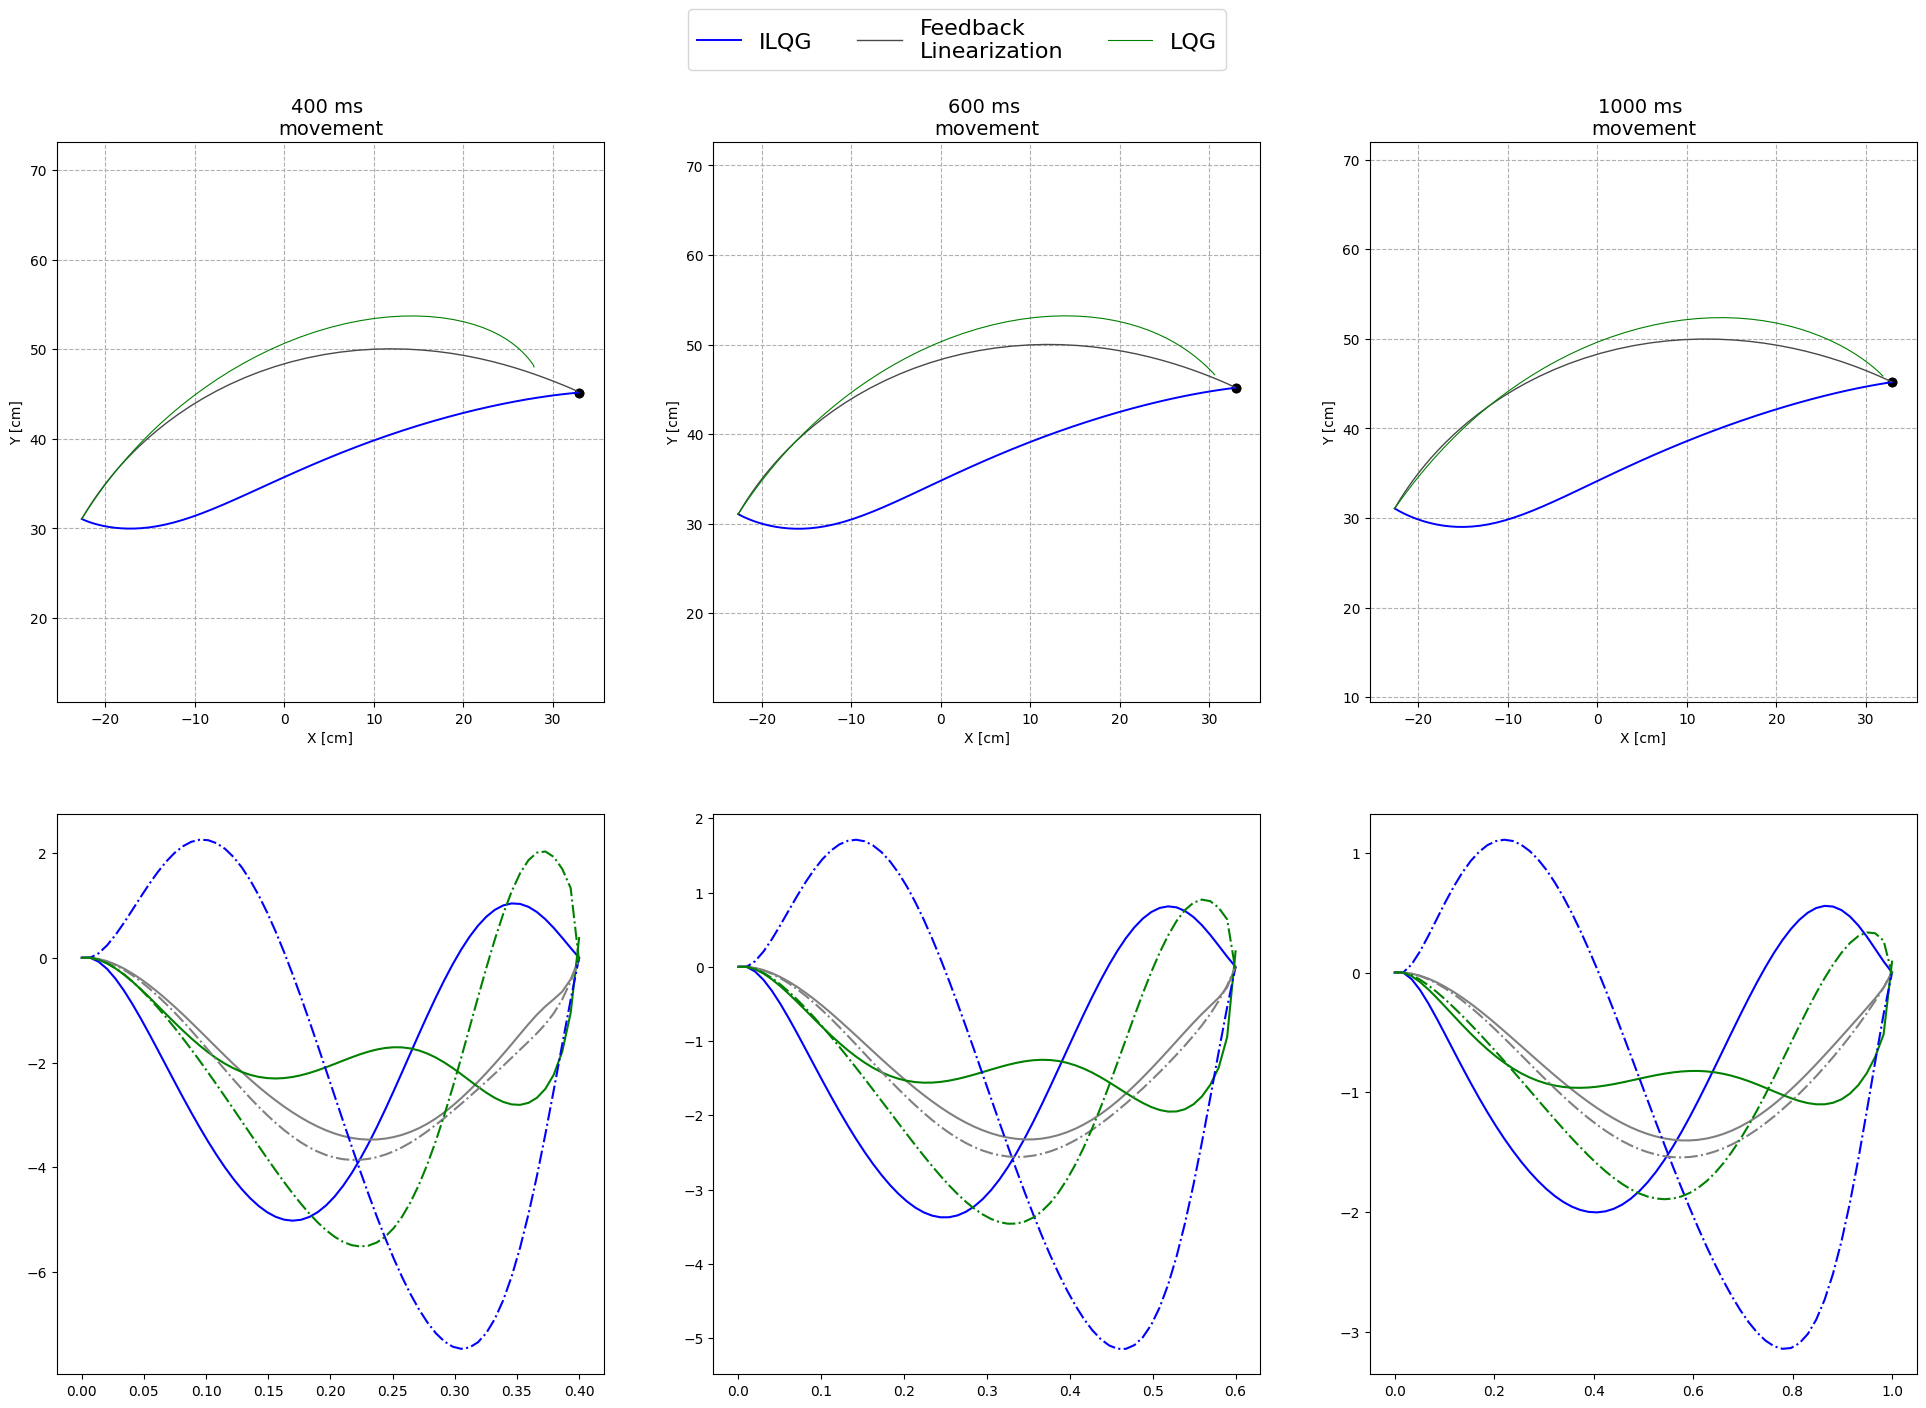

In [51]:

fig,ax = plt.subplots(2,3,figsize = (24,16))
T = [.4,.6,1]
tg = ToCartesian(np.array([25,55])/180*pi)
st = ToCartesian(np.array([70,105])/180*pi)

for i in range(3):
    plt.subplot(2,3,i+1)
    plt.axis("equal")
    D = T[i]
    K = 60
    xilqg = ILQG(Duration = D,targets = tg,start = st)[3]
    xfl = Feedback_Linearization(Duration = D,targets = tg,starting_point = st,ShowJ=True,Num_iter = K)[3]
    xlqg = BestLQG(Duration = D,targets = tg, starting_point=st)[3]
    plt.legend().remove()
    plt.title(str(int(T[i]*1000))+" ms \nmovement",fontsize = 14)
    if i == 0 : fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
    plt.subplot(2,3,i+4)
    t = np.linspace(0,D,K)
    plt.plot(t,xilqg[:,2],color = "blue")
    plt.plot(t,xfl[:,2],color = "grey")
    plt.plot(t,xlqg[1],color = "green")
    plt.plot(t,xilqg[:,3],color = "blue",linestyle = "-.")
    plt.plot(t,xfl[:,3],color = "grey",linestyle = "-.")
    plt.plot(t,xlqg[4],color = "green",linestyle = "-.")

plt.savefig("img/AlwaysOvershoot2.png",dpi = 200)


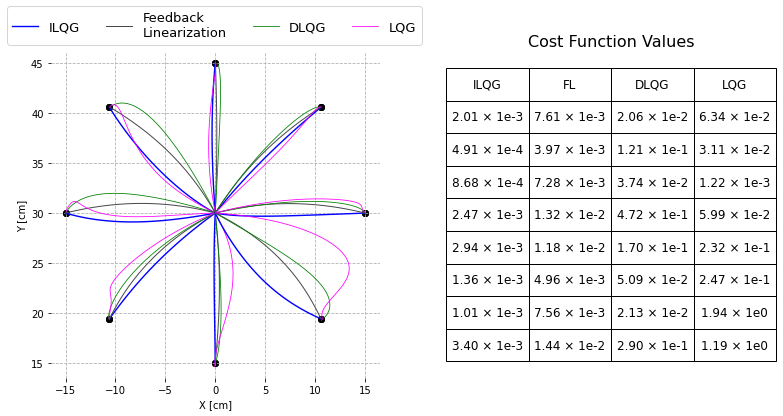

In [32]:

fig,ax = plt.subplots(1,2,figsize = (13,6))
T = [.4,.6,1]

st = np.array([0,30])
d = 15
angles = np.linspace(0,2*pi,9)[:-1]
K = 60
D = .6
plt.axis("equal")
r,w1,w2 = 1e-4,1e4,1
colors = ["blue","grey","green"]
CostArray=np.zeros((4,8))
for i in range(8):
    ax=plt.subplot(1,2,1)
    tg = st + np.array([d*cos(angles[i]),d*sin(angles[i])])
    obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,tg[0],tg[1]) 
    
    _,_,u,xilqg = ILQG(r1=r,w1=w1,w2=w2,Duration = D,targets = tg,start = st)
    JILQG = Compute_Cost_function(r,w1,w2,u,xilqg[-1],[obj1,obj2],False)
    _,_,u,xfl = Feedback_Linearization(Duration = D,targets = tg,starting_point = st,Showu=True,Num_iter = K)
    JFL = Compute_Cost_function(r,w1,w2,u,xfl[-1],[obj1,obj2],False)
    _,_,u,xlqg = BestLQG(Duration = D,targets = tg, starting_point=st,w1=w1,w2=w1,w3=w1,w4=w1,r1=r,r2=r)
    JBLQG = Compute_Cost_function(r,w1,w2,u,xlqg[:,-1],[obj1,obj2],True)
    _,_,u,xlqg = BestLQG(Duration = D,targets = tg, starting_point=st,w1=w1,w2=w1,w3=w1,w4=w1,r1=r,r2=r,ClassicLQG=True)
    JLQG = Compute_Cost_function(r,w1,w2,u,xlqg[:,-1],[obj1,obj2],True)
    plt.legend().remove()
    if i == 0 : fig.legend(loc='upper center', bbox_to_anchor=(0.3, 1),fontsize = 13,ncol = 4)
    CostArray[:,i]= np.array([JILQG,JFL,JBLQG,JLQG])


delete_axis(ax)
ax=plt.subplot(1,2,2)

ax.set_axis_off()
ax.set_title("Cost Function Values",fontsize = 16)
def format_number(value):
    formatted = "{:.2e}".format(value)  # Convert to scientific notation
    base, exponent = formatted.split("e")  # Split base and exponent
    return f"{base} × 1en".replace("n", str(int(exponent)))  # Format nicely

# Apply formatting to all data
formatted_data = [[format_number(x) for x in row] for row in CostArray.T]

# Create the table
table = ax.table(cellText=formatted_data, colLabels=["ILQG","FL","DLQG","LQG"], cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)  # Adjust font size

for key, cell in table.get_celld().items():
    cell.set_height(0.1)  # Increase row height
    

plt.savefig("img/CostFunctionCompared.png",dpi = 200)

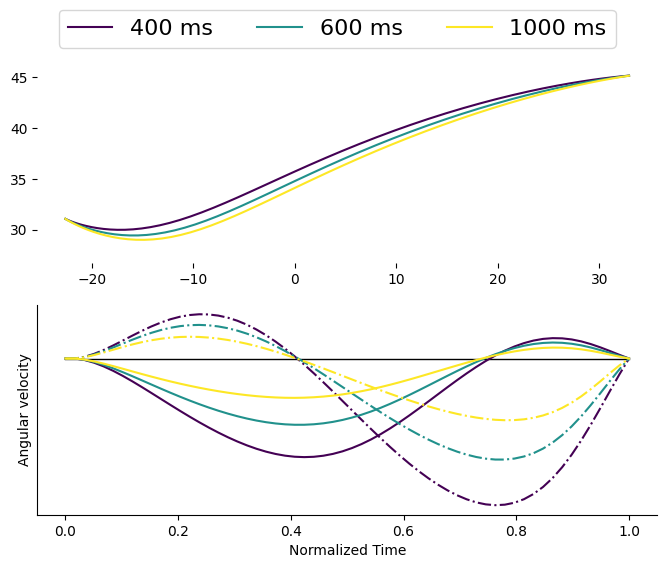

In [2]:
fig,ax = plt.subplots(2,1,figsize = (8,6))
T = [.4,.6,1]
tg = ToCartesian(np.array([25,55])/180*pi)
st = ToCartesian(np.array([70,105])/180*pi)
K = 60
Bdyn = np.array([[0.05,0.025],[0.025,0.05]])
colors = get_colors_from_colormap(3,"viridis")
t = np.linspace(0,1,K)
for i in range(3):
    plt.subplot(2,1,1)
    plt.axis("equal")
    D = T[i]

    X,Y,_,xilqg = ILQG(Duration = D,targets = tg,start = st,plot = False)
    plt.plot(X,Y,color = colors[i],label = str(int(T[i]*1000))+" ms")
    plt.subplot(2,1,2)
    if i == 0:plt.plot(t,np.zeros(len(t)),color = "black",linewidth = 1)
    plt.plot(t,xilqg[:,2],color = colors[i])
    plt.plot(t,xilqg[:,3],color = colors[i],linestyle = "-.")
ax = plt.subplot(2,1,1)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
delete_axis(ax)
ax = plt.subplot(2,1,2)
plt.ylabel("Angular velocity")
plt.xlabel("Normalized Time")
plt.yticks([])
delete_axis(ax,sides = ["right","top"])

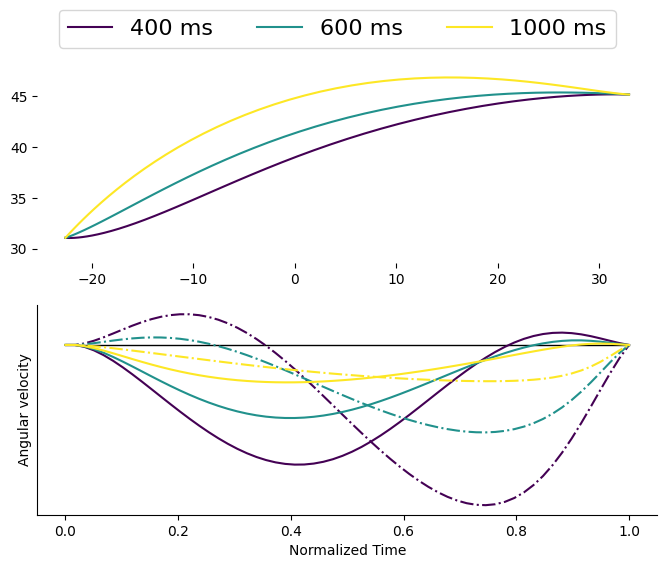

In [ ]:
if False:    
    fig,ax = plt.subplots(2,1,figsize = (8,6))
    T = [.4,.6,1]
    tg = ToCartesian(np.array([25,55])/180*pi)
    st = ToCartesian(np.array([70,105])/180*pi)
    K = 60

    colors = get_colors_from_colormap(3,"viridis")
    t = np.linspace(0,1,K)
    for i in range(3):
        plt.subplot(2,1,1)
        plt.axis("equal")
        D = T[i]

        X,Y,_,xilqg = ILQG(Duration = D,targets = tg,start = st,plot = False)
        plt.plot(X,Y,color = colors[i],label = str(int(T[i]*1000))+" ms")
        plt.subplot(2,1,2)
        if i == 0:plt.plot(t,np.zeros(len(t)),color = "black",linewidth = 1)
        plt.plot(t,xilqg[:,2],color = colors[i])
        plt.plot(t,xilqg[:,3],color = colors[i],linestyle = "-.")
    ax = plt.subplot(2,1,1)
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
    delete_axis(ax)
    ax = plt.subplot(2,1,2)
    plt.ylabel("Angular velocity")
    plt.xlabel("Normalized Time")
    plt.yticks([])
    delete_axis(ax,sides = ["right","top"])

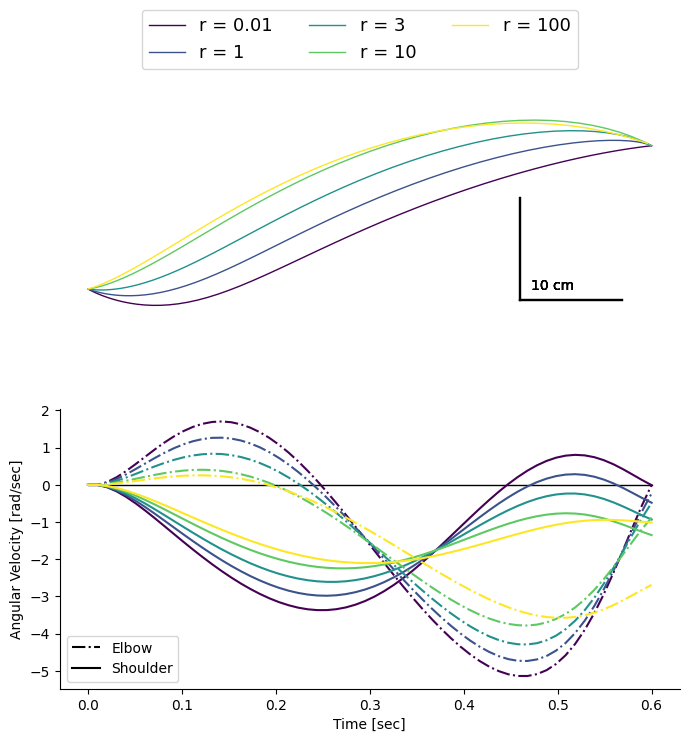

In [26]:


tg = ToCartesian(np.array([25,55])/180*pi)
st = ToCartesian(np.array([70,105])/180*pi)

D = .6
K = 60
R = [1e-2,1,3,10,100]
colors = get_colors_from_colormap(len(R),"viridis")
fig,ax = plt.subplots(2,1,figsize = (8,8))
plt.subplot(2,1,2)
t = np.linspace(0,D,K)
plt.plot(t,np.zeros(len(t)),color = "black",linewidth = 1)
for i in range(len(R)):
    ax1 = plt.subplot(2,1,1)
    plt.axis("equal")
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    add_scale_cm(20,30,10)
    r = R[i]
    wa = 1e4
    wv = 1
    X,Y,_,xilqg = ILQG(w1=wa,w2=wv,Duration = D,r1=r,targets = tg,start = st,plot = False)
    plt.plot(X,Y,label = "r = "+str(R[i]),linewidth = 1,color = colors[i])
    ax2 = plt.subplot(2,1,2)
    plt.plot(t,xilqg[:,2],color = colors[i])
    plt.plot(t,xilqg[:,3],color = colors[i],linestyle = "-.")
for side in ["left","right","bottom","top"] : ax1.spines[side].set_visible(False)    
for side in ["right","top"] : ax2.spines[side].set_visible(False)    
ax2.set_xlabel("Time [sec]")
ax2.set_ylabel("Angular Velocity [rad/sec]")
fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 13,ncol = 3)

plt.plot([0,0],[0,0],linestyle = "-.",color = "black",label = "Elbow")
plt.plot([0,0],[0,0],linestyle = "-",color = "black",label = "Shoulder")
plt.legend()

plt.savefig("img/Compare_Cost.png",dpi = 400)

# Second Movement

In [ ]:
T = [.4,.6,1]
tg = ToCartesian(np.array([-12,100])/180*pi)
st = ToCartesian(np.array([70,70])/180*pi)

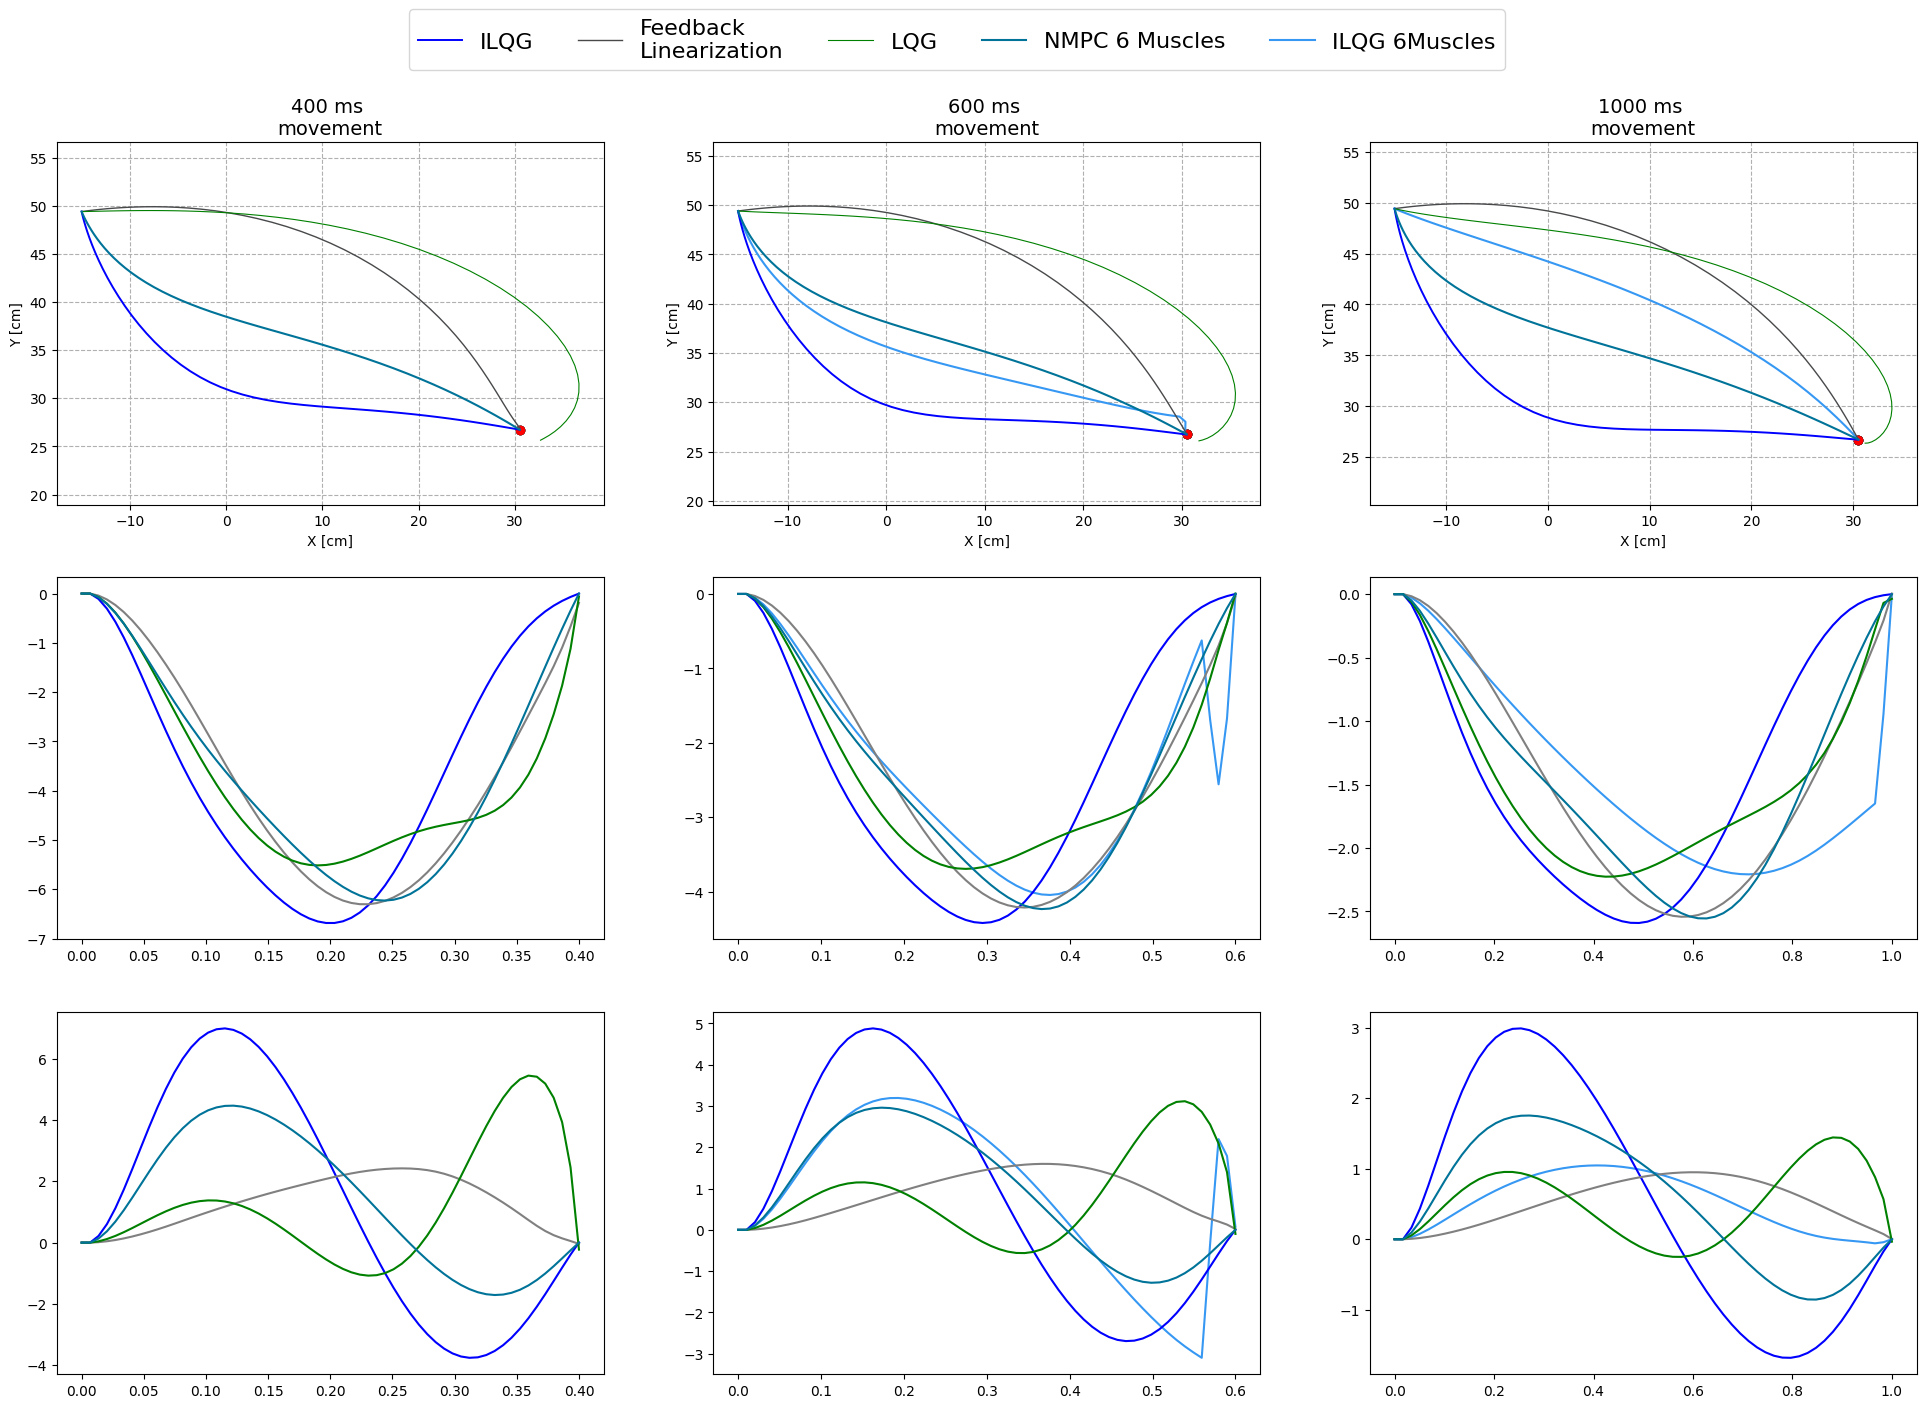

In [49]:
fig,ax = plt.subplots(3,3,figsize = (24,16))

for i in range(3):
    plt.subplot(3,3,i+1)
    plt.axis("equal")
    D = T[i]
    K = 60
    r = 1e-4
    if i>0: xmuscle = ILQGMuscle(Duration = D,r1 = r,K=K,targets = tg,start = st ,eps= 1e-3*5)[3]
    if i == 1 : fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
    xilqg = ILQG(Duration = D,K=K,targets = tg,start = st,r1 = r)[3]
    xfl = Feedback_Linearization(Duration = D,targets = tg,starting_point = st,ShowJ=True,Num_iter = K,r1=r,r2=r)[3]
    xlqg = BestLQG(Duration = D,targets = tg, starting_point=st,Num_iter=K,r1=r,r2=r)[3]
    xmpc = MPC42(Duration = D,end = tg, start=st,n_steps = K,r=r)
    plt.legend().remove()
    plt.title(str(int(T[i]*1000))+" ms \nmovement",fontsize = 14)
    
    plt.subplot(3,3,4+i)
    t = np.linspace(0,D,K)
    if i>0: plt.plot(t,xmuscle[:,2],color = "#3698f3")
    plt.plot(t,xilqg[:,2],color = "blue")
    plt.plot(t,xfl[:,2],color = "grey")
    plt.plot(t,xlqg[1],color = "green")
    plt.plot(t,xmpc[2],color = "#007399")

    plt.subplot(3,3,7+i)
    t = np.linspace(0,D,K)
    if i>0: plt.plot(t,xmuscle[:,3],color = "#3698f3")
    plt.plot(t,xilqg[:,3],color = "blue")
    plt.plot(t,xfl[:,3],color = "grey")
    plt.plot(t,xlqg[4],color = "green")
    plt.plot(t,xmpc[3],color = "#007399")

plt.savefig("img/AlwaysOvershoot3.png",dpi = 200)

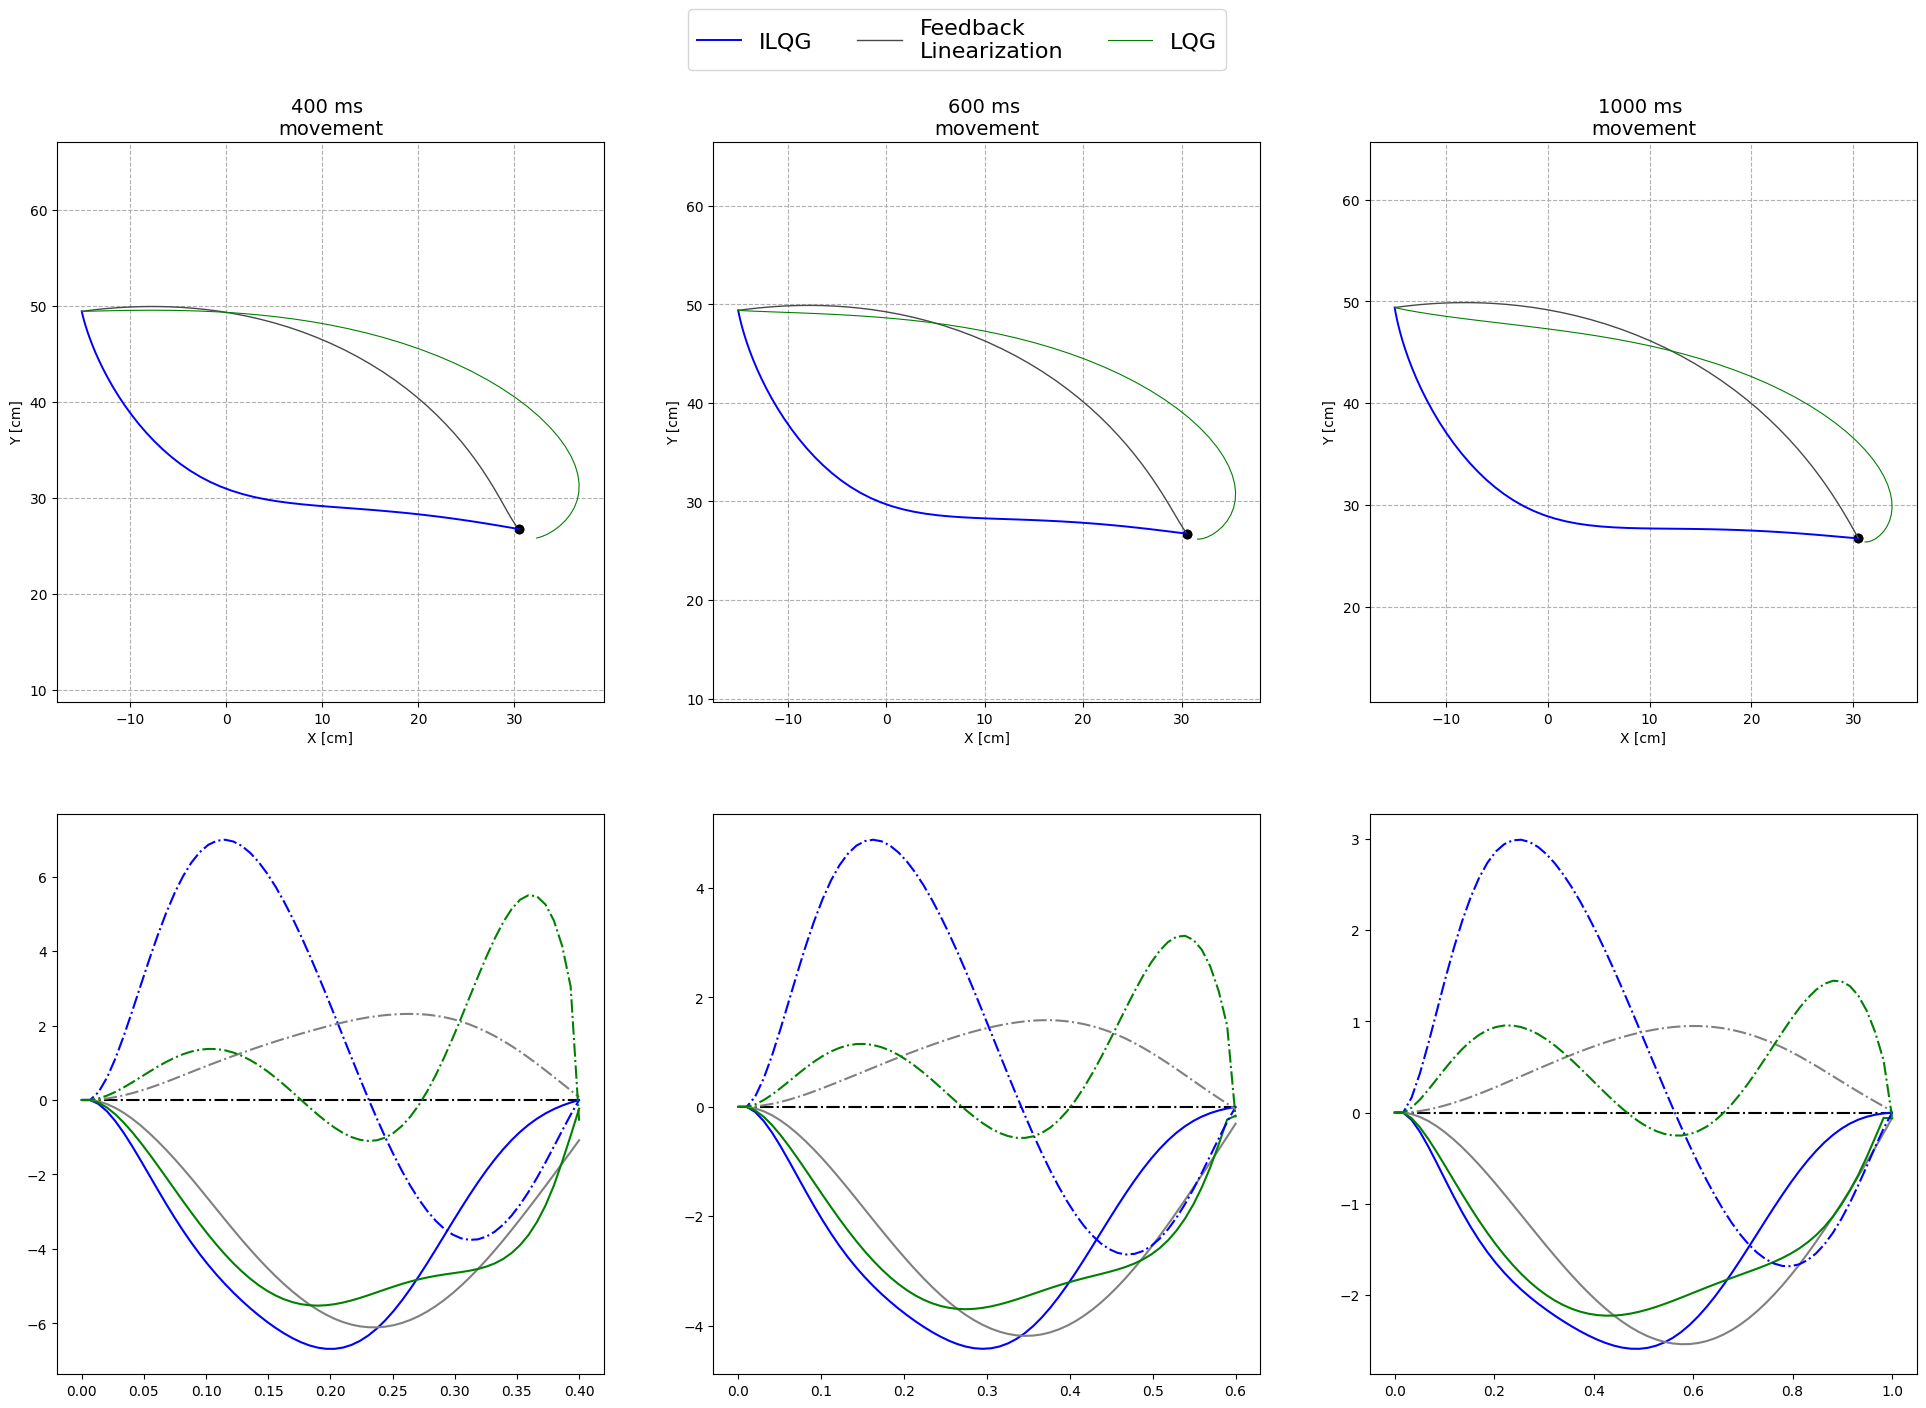

In [7]:

fig,ax = plt.subplots(2,3,figsize = (24,16))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.axis("equal")
    D = T[i]
    K = 60
    r = 1e-6
    wa = 1e4
    wv = 1
    xilqg = ILQG(w1=wa,w2=wv,Duration = D,r1=r,targets = tg,start = st)[3]
    xfl = Feedback_Linearization(Duration = D,targets = tg,starting_point = st,ShowJ=True,Num_iter = K,r1=r,r2=r,w1=wa,w2=wa,w3=wv,w4=wv)[3]
    xlqg = BestLQG(Duration = D,targets = tg, starting_point=st,r1=r,r2=r,w1=wa,w2=wa,w3=wv,w4=wv)[3]
    plt.legend().remove()
    plt.title(str(int(T[i]*1000))+" ms \nmovement",fontsize = 14)
    if i == 0 : fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 16,ncol = 5)
    plt.subplot(2,3,i+4)
    t = np.linspace(0,D,K)
    plt.plot(t,np.zeros(len(t)),linestyle = "-.",color = "black")
    plt.plot(t,xilqg[:,2],color = "blue")
    plt.plot(t,xfl[:,2],color = "grey")
    plt.plot(t,xlqg[1],color = "green")
    plt.plot(t,xilqg[:,3],color = "blue",linestyle = "-.")
    plt.plot(t,xfl[:,3],color = "grey",linestyle = "-.")
    plt.plot(t,xlqg[4],color = "green",linestyle = "-.")


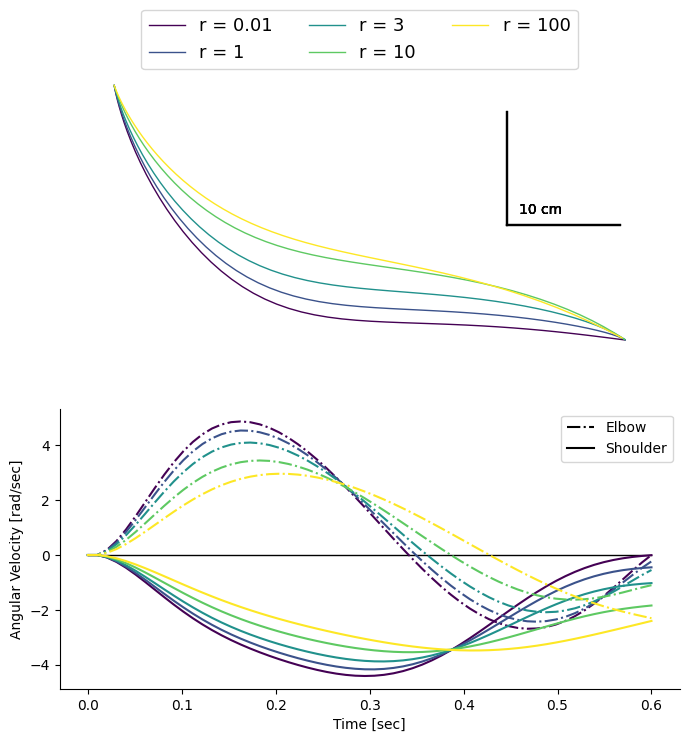

In [29]:
D = .6
K = 60
R = [1e-2,1,3,10,100]
colors = get_colors_from_colormap(len(R),"viridis")
fig,ax = plt.subplots(2,1,figsize = (8,8))
plt.subplot(2,1,2)
t = np.linspace(0,D,K)
plt.plot(t,np.zeros(len(t)),color = "black",linewidth = 1)
for i in range(len(R)):
    ax1 = plt.subplot(2,1,1)
    plt.axis("equal")
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    add_scale_cm(20,37,10)
    r = R[i]
    wa = 1e4
    wv = 1
    X,Y,_,xilqg = ILQG(w1=wa,w2=wv,Duration = D,r1=r,targets = tg,start = st,plot = False)
    plt.plot(X,Y,label = "r = "+str(R[i]),linewidth = 1,color = colors[i])
    ax2 = plt.subplot(2,1,2)
    plt.plot(t,xilqg[:,2],color = colors[i])
    plt.plot(t,xilqg[:,3],color = colors[i],linestyle = "-.")
for side in ["left","right","bottom","top"] : ax1.spines[side].set_visible(False)    
for side in ["right","top"] : ax2.spines[side].set_visible(False)    
ax2.set_xlabel("Time [sec]")
ax2.set_ylabel("Angular Velocity [rad/sec]")


fig.legend(loc='upper center', bbox_to_anchor=(0.5, .97),fontsize = 13,ncol = 3)
plt.plot([0,0],[0,0],linestyle = "-.",color = "black",label = "Elbow")
plt.plot([0,0],[0,0],linestyle = "-",color = "black",label = "Shoulder")


plt.legend()

plt.savefig("img/Compare_Cost2.png",dpi = 400)